In [7]:
#SET ALPHA
ALPHA = 0.8

import matplotlib.pyplot as plt
%matplotlib inline


In [95]:
import re
def get_num_references(text):
    numref = len(re.findall('@', text))
    return numref

def get_num_hashtags(text):
    numref = len(re.findall('#', text))
    return numref

def get_num_links(text):
    numlinks = len(re.findall('https?:\/\/', text))
    return numlinks

def remove_links(text):
    clean_text = re.sub('https?:\/\/.*\..+\/.*\s?', '', text)
    return clean_text

def remove_reference(text):
    clean_text = re.sub('@\w+(\s|:)?', '', text)
    return clean_text

def clean_text(text):
    cleaned_text = re.sub('^b\'?','', text)
    cleaned_text = re.sub('\'$', '', cleaned_text)
    return cleaned_text

def preprocess_text(text):
    return remove_links(remove_reference(clean_text(text)))

def clean_text_2(text):
    clean_text = re.sub('\'', '', text)
    clean_text = re.sub('[^a-zA-Z0-9]', ' ', clean_text)
    clean_text = re.sub(' s ', ' ', clean_text)
    return clean_text

def preprocess_text_2(text):
    return clean_text_2(remove_links(remove_reference(text)))

def compute_engagement_score(retweets,fav):
    return ALPHA*retweets+(1-ALPHA)*fav

#def get_day_hour(text):
#    m = re.match("\d+-\d+-\d+ (\d+):.*", text)
#    return int(m.group(1))
    
def get_day_hour(text):
    m = re.match("^\w\w\w \w\w\w \d\d (\d\d)*", text)
    return int(m.group(1))

def get_weekday_mon(text):
    m = re.match("^(\w\w\w) \w\w\w \d\d \d\d:\d\d:\d\d*", text)
    return 1 if (m.group(1) == "Mon") else 0

def get_weekday_tue(text):
    m = re.match("^(\w\w\w) \w\w\w \d\d \d\d:\d\d:\d\d*", text)
    return 1 if (m.group(1) == "Tue") else 0

def get_weekday_wed(text):
    m = re.match("^(\w\w\w) \w\w\w \d\d \d\d:\d\d:\d\d*", text)
    return 1 if (m.group(1) == "Wed") else 0

def get_weekday_thu(text):
    m = re.match("^(\w\w\w) \w\w\w \d\d \d\d:\d\d:\d\d*", text)
    return 1 if (m.group(1) == "Thu") else 0

def get_weekday_fri(text):
    m = re.match("^(\w\w\w) \w\w\w \d\d \d\d:\d\d:\d\d*", text)
    return 1 if (m.group(1) == "Fri") else 0

def get_weekday_sat(text):
    m = re.match("^(\w\w\w) \w\w\w \d\d \d\d:\d\d:\d\d*", text)
    return 1 if (m.group(1) == "Sat") else 0


### Generate feature vector:

In [24]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np

def generate_feature_vector(raw_data):
    
    # Get cleaned text
    for i in raw_data.index:
        raw_data.ix[i, 'TC'] = preprocess_text_2(raw_data.ix[i, 'T'])
    
    vectorizer = CountVectorizer(min_df=1, ngram_range=[1,1])
    analyze = vectorizer.build_analyzer()
    X = vectorizer.fit_transform(raw_data['TC']).toarray()
    
    transformer = TfidfTransformer()
    tfidf = transformer.fit_transform(X)
    #tfidf.toarray()
    
    feature_df = pd.DataFrame(columns=vectorizer.get_feature_names()+
                          ['num_references','num_hastags','num_links','time of day','wd_mon','wd_tue','wd_wed','wd_thu','wd_fri','wd_sat','Y'],
                          index = range(0,len(raw_data)))
        
    j=0
    for i in tfidf.toarray():
        feature_df.iloc[j] = i.tolist() + [get_num_references(raw_data.iloc[j]['T']),
                                       get_num_hashtags(raw_data.iloc[j]['T']),
                                       get_num_links(raw_data.iloc[j]['T']),
                                       get_day_hour(raw_data.iloc[j]['D']),
                                       get_weekday_mon(raw_data.iloc[j]['D']),
                                       get_weekday_tue(raw_data.iloc[j]['D']),
                                       get_weekday_wed(raw_data.iloc[j]['D']),
                                       get_weekday_thu(raw_data.iloc[j]['D']),
                                       get_weekday_fri(raw_data.iloc[j]['D']),
                                       get_weekday_sat(raw_data.iloc[j]['D']),
                                       compute_engagement_score(raw_data.iloc[j]['R'],
                                                                raw_data.iloc[j]['F'])]
        j = j + 1
    

    return feature_df

#import twokenize as tw
#tw.normalizeTextForTagger(raw_data.iloc[1]['tweet'])
#tw.tokenizeRawTweetText(raw_data.iloc[1]['tweet'])
#tw.simpleTokenize(raw_data.iloc[1]['tweet'])

#for i in raw_data.index:
#    raw_data.ix[i, 'TC'] = preprocess_text_2(raw_data.ix[i, 'T'])
#raw_data

In [4]:


raw_data = pd.read_csv('data/NYUDS_realdonaldtrump_final_nolinebreaks.csv',
                       header = None, 
                       names = ['D','T','R','F','NA'])

fv = generate_feature_vector(raw_data)
#fv.ix[0,:]
fv.columns

Index([         u'00',         u'000',         u'00a',        u'00am',
              u'00pm',     u'00pmest',          u'01',          u'03',
                u'08',          u'09',
       ...
       u'num_hastags',   u'num_links', u'time of day',      u'wd_mon',
            u'wd_tue',      u'wd_wed',      u'wd_thu',      u'wd_fri',
            u'wd_sat',           u'Y'],
      dtype='object', length=5021)

In [5]:
from sklearn.cross_validation import train_test_split

Y = fv['Y']
X = fv.drop('Y', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

In [73]:
#############################################################
### Support Vector Regression ###############################
#############################################################

from sklearn.svm import SVR
from sklearn import metrics

svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_lin = SVR(kernel='linear', C=1e3)
svr_poly = SVR(kernel='poly', C=1e3, degree=2)
y_rbf = svr_rbf.fit(X_train, y_train).predict(X_test)
y_lin = svr_lin.fit(X_train, y_train).predict(X_test)
y_poly = svr_poly.fit(X_train, y_train).predict(X_test)



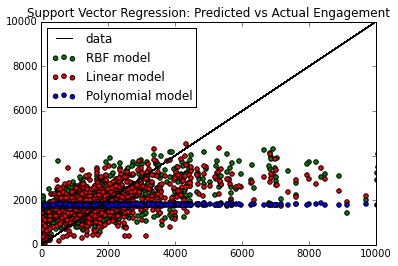

In [74]:

plt.plot(y_test, y_test, c='k', label='data')
plt.scatter(y_test, y_rbf, c='g', label='RBF model')
plt.scatter(y_test, y_lin, c='r', label='Linear model')
plt.scatter(y_test, y_poly, c='b', label='Polynomial model')
plt.xlim(0, 10000)
plt.ylim(0, 10000)
plt.legend(loc="upper left")
plt.title("Support Vector Regression: Predicted vs Actual Engagement")
plt.show()

### Takeaways:
# Polynomial clearly unsuitable, at least with default hyperparameters
# RBF, linear show some promise, apparently better than random

### To-do:
# Try different hyperparameter values
# Generate some accuracy metrics


In [94]:
from sklearn import grid_search

parameters = {'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 'C': [1, 10, 100, 1000]}
svr = SVR()
gs_svr = grid_search.GridSearchCV(svr, parameters)
gs_svr.fit(X_train, y_train)
gs_svr.best_params_

{'C': 1000, 'kernel': 'linear'}

In [96]:
svr_opt = SVR(kernel='linear', C=1000)
y_opt = svr_lin.fit(X_train, y_train).predict(X_test)

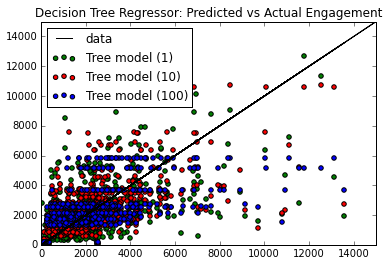

In [75]:
from sklearn import tree

tree1 = tree.DecisionTreeRegressor(min_samples_leaf=1)
tree10 = tree.DecisionTreeRegressor(min_samples_leaf=10)
tree100 = tree.DecisionTreeRegressor(min_samples_leaf=100)
y_tree1 = tree1.fit(X_train, y_train).predict(X_test)
y_tree10 = tree10.fit(X_train, y_train).predict(X_test)
y_tree100 = tree100.fit(X_train, y_train).predict(X_test)

plt.plot(y_test, y_test, c='k', label='data')
plt.scatter(y_test, y_tree1, c='g', label='Tree model (1)')
plt.scatter(y_test, y_tree10, c='r', label='Tree model (10)')
plt.scatter(y_test, y_tree100, c='b', label='Tree model (100)')
plt.xlim(0, 15000)
plt.ylim(0, 15000)
plt.legend(loc="upper left")
plt.title("Decision Tree Regressor: Predicted vs Actual Engagement")

### Takeaways:
# 1-sample leaf model shows some promise, but likely overfits
# 100 may be too restrictive

### To-do:
# Generate some accuracy metrics to confirm whether 10 (or other value) is ideal




In [87]:

parameters = {'min_samples_leaf':[1, 2, 5, 10, 20, 50, 100, 200, 500]}
dtr = tree.DecisionTreeRegressor()
gs_tree = grid_search.GridSearchCV(dtr, parameters)
gs_tree.fit(X_train, y_train)

gs_tree.best_params_

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, random_state=None,
           splitter='best'),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'min_samples_leaf': [1, 2, 5, 10, 20, 50, 100, 200, 500]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

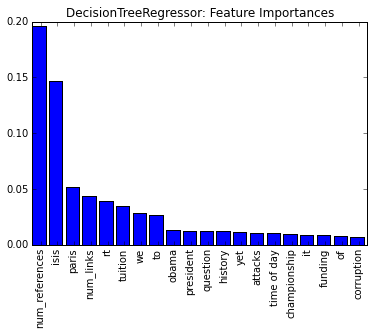

In [77]:
#X_train.columns
#tree1.feature_importances_


importances = pd.DataFrame(X_train.columns, columns=['feature'])
importances['score'] = tree1.feature_importances_
importances = importances.sort_values(by='score', ascending=False)
#importances

top_imp = importances[0:20]
#top_imp

plt.figure()
plt.bar(range(top_imp.shape[0]), top_imp['score'])
plt.xticks(np.arange(0.5, 20.5, 1), top_imp['feature'].values, rotation='vertical')
plt.title("DecisionTreeRegressor: Feature Importances")
plt.show()


#for f in range(X_train.shape[1]):
#    print("%d. %s\t%f" % (f, X_train.columns[f], tree1.feature_importances_[f]))
    

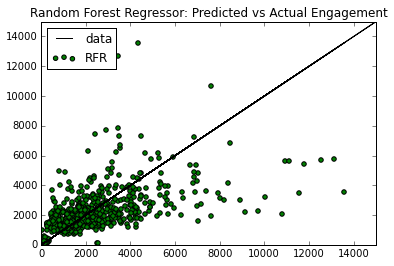

In [78]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
y_rfr = rfr.fit(X_train, y_train).predict(X_test)

plt.plot(y_test, y_test, c='k', label='data')
plt.scatter(y_test, y_rfr, c='g', label='RFR')
plt.xlim(0, 15000)
plt.ylim(0, 15000)
plt.legend(loc="upper left")
plt.title("Random Forest Regressor: Predicted vs Actual Engagement")


In [102]:
parameters = {'n_estimators':[16], 'max_features':[0.40], 'min_samples_leaf':[1, 10]}
rfr = RandomForestRegressor()
gs_rf = grid_search.GridSearchCV(rfr, parameters)
gs_rf.fit(X_train, y_train)

gs_rf.best_params_

{'max_features': 0.4, 'min_samples_leaf': 1, 'n_estimators': 16}

In [107]:
rfr_opt = RandomForestRegressor(n_estimators=16, max_features=0.4, min_samples_leaf=1)
rfr_opt.fit(X_train, y_train).predict(X_test)
y_rfr_opt = rfr_opt.predict(X_test)

In [108]:

errors = dict()

#errors['SVM: RBF'] = metrics.mean_absolute_error(y_test, y_rbf)
#errors['SVM: Linear'] = metrics.mean_absolute_error(y_test, y_lin)
#errors['SVM: Polynomial'] = metrics.mean_absolute_error(y_test, y_poly)
errors['Support Vector Regression'] = metrics.mean_absolute_error(y_test, y_opt)
#errors['Tree_1'] = metrics.mean_absolute_error(y_test, y_tree1)
#errors['Tree_10'] = metrics.mean_absolute_error(y_test, y_tree10)
errors['Decision Tree'] = metrics.mean_absolute_error(y_test, y_tree100)
#errors['RF'] = metrics.mean_absolute_error(y_test, y_rfr)
errors['Random Forest'] = metrics.mean_absolute_error(y_test, y_rfr_opt)

errors

{'Decision Tree': 997.2117109797307,
 'Random Forest': 920.57629242496171,
 'Support Vector Regression': 1044.8079197525501}

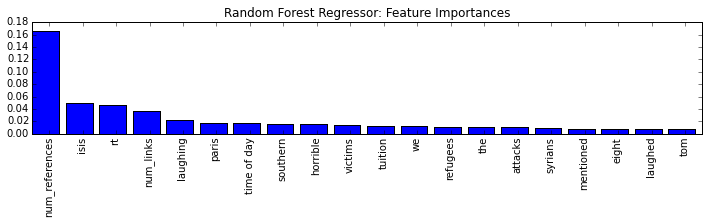

In [121]:
#rfr_opt.fit(X_train, y_train)
importances = pd.DataFrame(X_train.columns, columns=['feature'])
importances['score'] = rfr_opt.feature_importances_
importances = importances.sort_values(by='score', ascending=False)
#importances

top_imp = importances[0:20]
#top_imp

plt.rcParams['figure.figsize'] = 12, 2
plt.figure()
plt.bar(range(top_imp.shape[0]), top_imp['score'])
plt.xticks(np.arange(0.5, 20.5, 1), top_imp['feature'].values, rotation='vertical')
plt.title("Random Forest Regressor: Feature Importances")
plt.show()

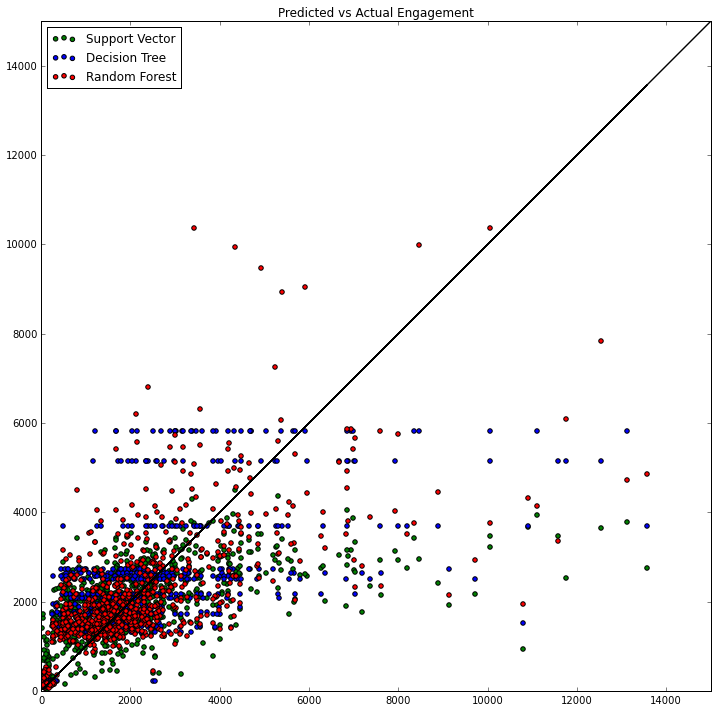

In [116]:
plt.rcParams['figure.figsize'] = 12, 12
plt.plot(y_test, y_test, c='k')
plt.scatter(y_test, y_opt, c='g', label='Support Vector')
plt.scatter(y_test, y_tree100, c='b', label='Decision Tree')
plt.scatter(y_test, y_rfr_opt, c='r', label='Random Forest')
plt.xlim(0, 15000)
plt.ylim(0, 15000)
plt.legend(loc="upper left")
plt.title("Predicted vs Actual Engagement")